[10387 - Scientific Computing in Quantum Information Science](https://kurser.dtu.dk/course/10387)

# Faster code

Pure Python can be rather slow. There are many ways to speed it up - first and foremost by making use of array computation through NumPy.

But it can often get even faster, using tools like [Numba](), [numexpr](), [PyPy](https://doc.pypy.org/en/latest/index.html), and [Cython](https://cython.readthedocs.io/en/latest/src/quickstart/cythonize.html) or by parallelizing computations using e.g. the built-in [multiprocessing](). These can be challenging to use and may not be compatible with your existing code, so only use them when optimisation is really crucial.

In [1]:
from math import sqrt
import numpy as np
import numexpr as ne
from numba import njit
from functools import lru_cache
from functools import wraps
%load_ext line_profiler
# import cython
# import multiprocessing as mp

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [6]:
rng = np.random.default_rng()
A = rng.standard_normal((1000_000, 3))

In [8]:
def norm1():
    """Pure Python"""
    return [sqrt(a[0]**2 + a[1]**2 + a[2]**2) for a in A]

def norm2():
    """Simple NumPy using np.sum"""
    return np.sqrt(np.sum(A**2, axis=1))

def norm3():
    """np.linalg.norm"""
    return np.linalg.norm(A, axis=1)

@njit
def norm4():
    """Numba on pure Python"""
    return [np.sqrt(a[0]**2 + a[1]**2 + a[2]**2) for a in A]

@njit
def norm5():
    """Numba on simple NumPy"""
    return np.sqrt(np.sum(A**2, axis=1))

@njit
def norm6():
    """Numba on NumPy with 'manual' sum of coordinates"""
    A1, A2, A3 = A.T
    return np.sqrt(A1**2 + A2**2 + A3**2)
    
def norm7():
    """numexpr on simple NumPy (but np.sqrt external since sum must be evaluated last)"""
    return np.sqrt(ne.evaluate('sum(A**2, axis=1)'))

def norm8():
    """numexpr on NumPy with 'manual' sum of coordinates"""
    A1, A2, A3 = A.T
    return ne.evaluate('sqrt(A1**2 + A2**2 + A3**2)')

In [11]:
tim = %timeit -o norm8()

1.5 ms ± 13.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
tim.best

0.001471212135000087

In [13]:
tim.average

0.0014963133637143074

In [14]:
funcs = [eval(f'norm{i}') for i in range(1,9)]

In [15]:
for func in [norm1, norm2, norm3, norm4, norm5, norm6, norm7, norm8]:
    print(func.__name__)
    print(func.__doc__)
    print('Matches reference function output? ', np.allclose(norm1(), func()))
    %timeit func()
    print('-'*30)

norm1
Pure Python
Matches reference function output?  True
475 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
------------------------------
norm2
Simple NumPy using np.sum
Matches reference function output?  True
13.5 ms ± 201 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
------------------------------
norm3
np.linalg.norm
Matches reference function output?  True
13.7 ms ± 242 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
------------------------------
norm4
Numba on pure Python
Matches reference function output?  True
18.6 ms ± 688 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
------------------------------
norm5
Numba on simple NumPy
Matches reference function output?  True
9.76 ms ± 291 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
------------------------------
norm6
Numba on NumPy with 'manual' sum of coordinates
Matches reference function output?  True
2.09 ms ± 37.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops e

Demo of `lru_cache` which can speed up functions that are called repeatedly significantly, although it doesn't work with NumPy arrays.

Taken from https://www.geeksforgeeks.org/python-functools-lru_cache/.

In [16]:
def fib_without_cache(n): 
    if n < 2: 
        return n 
    return fib_without_cache(n-1) + fib_without_cache(n-2) 
      
%timeit fib_without_cache(30);

@lru_cache 
def fib_with_cache(n): 
    if n < 2: 
        return n 
    return fib_with_cache(n-1) + fib_with_cache(n-2) 
      
%timeit fib_with_cache(30);

83.4 ms ± 805 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.7 ns ± 0.261 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


## Profiling and refactoring

Now we'll try to program a tiny 1-qubit circuit consisting of one $R_x(\phi)$ gate followed by an $R_z(\phi)$ gate. We will then calculate the outputs of that for many pairs of $(\phi,\theta)$ values.

The [definition](https://omni.wikiwand.com/en/articles/List_of_quantum_logic_gates#Rotation_operator_gates) of the two gates: 

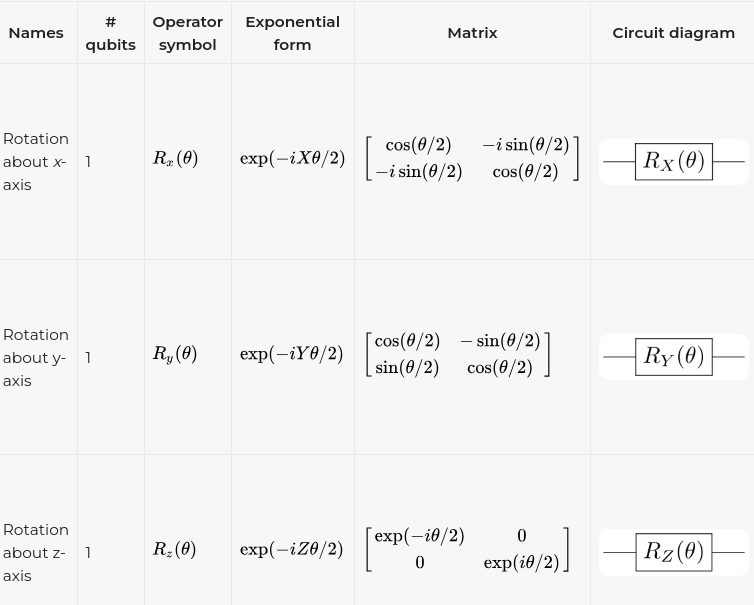

In [29]:
from scipy.linalg import expm

X = np.array([[0,1], [1,0]])
Z = np.array([[1,0], [0,-1]])

def RX(phi):
    out = expm(-1j * phi/2 * X)
    return out

def RZ(phi):
    out = expm(-1j * phi/2 * Z)
    return out

@np.vectorize
def circuit(phi, theta):
    ket0 = np.array([1,0])
    U = RZ(theta) @ RX(phi)
    out = U @ ket0
    return out

In [18]:
circuit(np.pi/4, np.pi/4)

array([0.854-0.354j, 0.146-0.354j])

In [41]:
phis = np.linspace(0, 2*np.pi, 100)
thetas = np.linspace(0, 2*np.pi, 200)
P, T = np.meshgrid(phis, thetas, indexing='xy')

In [22]:
phis.shape, thetas.shape

((100,), (200,))

In [23]:
P.shape

(100, 200)

In [24]:
phis[::20], thetas[::40]

(array([0.   , 1.269, 2.539, 3.808, 5.077]),
 array([0.   , 1.263, 2.526, 3.789, 5.052]))

In [25]:
P[::20,::40]

array([[0.   , 0.   , 0.   , 0.   , 0.   ],
       [1.269, 1.269, 1.269, 1.269, 1.269],
       [2.539, 2.539, 2.539, 2.539, 2.539],
       [3.808, 3.808, 3.808, 3.808, 3.808],
       [5.077, 5.077, 5.077, 5.077, 5.077]])

In [26]:
T[::20,::40]

array([[0.   , 1.263, 2.526, 3.789, 5.052],
       [0.   , 1.263, 2.526, 3.789, 5.052],
       [0.   , 1.263, 2.526, 3.789, 5.052],
       [0.   , 1.263, 2.526, 3.789, 5.052],
       [0.   , 1.263, 2.526, 3.789, 5.052]])

In [27]:
circuit(phis, thetas)

ValueError: operands could not be broadcast together with shapes (200,) (2,2) 

In [30]:
circuit(P, T)

TypeError: only length-1 arrays can be converted to Python scalars

In [31]:
def RX(phi):
    phi = np.atleast_1d(phi)
    phiX = phi[...,None,None] * X
    out = expm(-1j * phiX)
    return out

def RZ(phi):
    phi = np.atleast_1d(phi)
    phiZ = phi[...,None,None] * Z
    out = expm(-1j * phiZ)
    return out

def circuit2(phi, theta):
    ket0 = np.array([1,0])
    U = RZ(theta) @ RX(phi)
    out = U @ ket0
    return out

In [33]:
circuit2(P, T).shape

(100, 200, 2)

In [34]:
%timeit circuit2(P, T)

1.34 s ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%prun circuit2(P,T)

         907047 function calls (907024 primitive calls) in 1.578 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.793    0.793    1.000    1.000 {built-in method time.sleep}
        1    0.196    0.196    1.419    1.419 2061639054.py:1(RX)
        2    0.183    0.091    0.280    0.140 _matfuncs.py:213(expm)
   108600    0.127    0.000    0.127    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   108600    0.081    0.000    0.221    0.000 fromnumeric.py:71(_wrapreduction)
   108600    0.058    0.000    0.279    0.000 fromnumeric.py:2692(max)
    40400    0.041    0.000    0.082    0.000 twodim_base.py:234(diag)
   108601    0.013    0.000    0.013    0.000 {method 'items' of 'dict' objects}
      4/1    0.012    0.003    0.000    0.000 {method 'poll' of 'select.epoll' objects}
    20200    0.010    0.000    0.010    0.000 {method 'diagonal' of 'numpy.ndarray' objects}
    20200    0.010    0.000    0.024    0

In [35]:
%lprun -f circuit2 circuit2(P, T)

Timer unit: 1e-09 s

Total time: 1.6086 s
File: /run/user/1000/app/org.jupyter.JupyterLab/ipykernel_294/2061639054.py
Function: circuit2 at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def circuit2(phi, theta):
    14         1      33849.0  33849.0      0.0      ket0 = np.array([1,0])
    15         1 1607938840.0    2e+09    100.0      U = RZ(theta) @ RX(phi)
    16         1     625263.0 625263.0      0.0      out = U @ ket0
    17                                               return out

In [36]:
%lprun -f RZ circuit2(P, T)

Timer unit: 1e-09 s

Total time: 0.134644 s
File: /run/user/1000/app/org.jupyter.JupyterLab/ipykernel_294/2061639054.py
Function: RZ at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def RZ(phi):
     8         1      26104.0  26104.0      0.0      phi = np.atleast_1d(phi)
     9         1    1267674.0    1e+06      0.9      phiZ = phi[...,None,None] * Z
    10         1  133349803.0    1e+08     99.0      out = expm(-1j * phiZ)
    11                                               return out

In [37]:
RZ(T).shape

(100, 200, 2, 2)

In [38]:
RZ(thetas).shape, RX(phis).shape

((200, 2, 2), (100, 2, 2))

In [42]:
RZRX1 = RZ(T) @ RX(P)
RZRX2 = np.einsum('ikl,jlm', RZ(thetas), RX(phis))

In [43]:
np.allclose(RZRX1, RZRX2)

True

In [44]:
RZRX2.shape

(200, 100, 2, 2)

In [45]:
def circuit3(phi, theta):
    ket0 = np.array([1,0])
    U = np.einsum('ikl,jlm', RZ(theta), RX(phi))
    out = U @ ket0
    return out

In [46]:
out2 = circuit3(phis, thetas)

In [47]:
%timeit circuit2(P, T)
%timeit circuit3(phis, thetas)

1.34 s ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.4 ms ± 61 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%lprun -f circuit2 circuit2(P, T)

In [ ]:
%lprun -f circuit3 circuit3(phis, thetas)

### Refactoring

In [ ]:
def RX2(phi):
    phi = np.atleast_1d(phi)
    phiX = phi[...,None,None] * X
    out = np.array([[np.cos(phi/2), -1j*np.sin(phi/2)], [-1j*np.sin(phi/2), np.cos(phi/2)]])
    return out

def RZ(phi):
    phi = np.atleast_1d(phi)
    phiZ = phi[...,None,None] * Z
    out = expm(-1j * phiZ)
    return out

def circuit4(phi, theta):
    ket0 = np.array([1,0])
    U = RZ(theta) @ RX(phi)
    out = U @ ket0
    return out

In [ ]:
np.allclose(np.transpose(RX2(phis), (2,0,1)), RX(phis))

In [ ]:
np.transpose(RX2(phis), (2,0,1)) -  RX(phis)

## Sampling the circuit

In [ ]:
(abs(circuit2(phis, thetas)[:,:,0])**2).mean()

In [ ]:
rng = np.random.default_rng()
out_states = circuit2(phis, thetas)
probs = abs(out_states)**2

In [ ]:
probs[...,0]+probs[...,1]

In [ ]:
pre_samples = rng.uniform(0, 1, size=out_states.shape[:2])
measurements = (pre_samples < probs[...,1]).astype(int)